# GLM: Negative Binomial Regression
---
---

This notebook demos negative binomial regression using the *Turing* submodule.

Negative binomial regression is used to model count data for which the variance is higher than the mean. The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance.

**Import required libraries**

We start by importing the required libraries

In [1]:
using Turing, Distributions, Distributed, MCMCChains

using DataFrames, Plots, StatsPlots, LinearAlgebra

using Random
Random.seed!(12);

Turing.turnprogress(false);

loaded


┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/riteshk/.julia/packages/Turing/yF1Mq/src/Turing.jl:24


## Generate Data

**Note:** We first generate data using Poisson distribution and then generate the data using Negative Binomial distribution. This will help us to see the difference between the two distributions and how Negative Binomial distribution is a generalization over Poisson distribution.

We start off by creating a toy dataset.

    We take the case of a person who takes medicines to prevent excessive sneezing. Alcohol consumption increases the rate of sneezing for that person. Thus, the two factors affecting the number of sneezes in a given day are alcohol consumption and whether the person has taken his medicine. Both these variable are taken as boolean valued while the number of sneezes will be a count valued variable. We also take into consideration that the interaction between the two boolean variables will affect the number of sneezes.
    
As in the Poisson regression example, we assume that sneezing occurs at some baseline rate, and that consuming alcohol, not taking antihistamines, or doing both, increase its frequency.

**Assumptions:**

* The subject sneezes N times per day, recorded as nsneeze (int)
* The subject may or may not drink alcohol during that day, recorded as alcohol (boolean)
* The subject may or may not take an antihistamine medication during that day, recorded as the negative action nomeds (boolean)
* The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for alcohol and antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.

In [2]:
θ_noalcohol_meds = 1    # no alcohol, took a medicine
θ_alcohol_meds = 3      # alcohol, took a medicine
θ_noalcohol_nomeds = 6  # no alcohol, no medicine
θ_alcohol_nomeds = 36   # alcohol, no medicine

# no of samples for each of the above cases
q = 1000

df_pois = DataFrame(
            nsneeze=vcat(rand(Poisson(θ_noalcohol_meds), q),
                    rand(Poisson(θ_alcohol_meds), q),
                    rand(Poisson(θ_noalcohol_nomeds), q),
                    rand(Poisson(θ_alcohol_nomeds), q)),
            alcohol=vcat(zeros(q),
                    ones(q),
                    zeros(q),
                    ones(q)),
            nomeds=vcat(zeros(q),
                    zeros(q),
                    ones(q),
                    ones(q)));

**View means of the various combinations (Poisson mean values)**

In [3]:
by(df_pois, [:nomeds, :alcohol], :nsneeze => mean, :nsneeze => var)

,nomeds,alcohol,nsneeze_mean,nsneeze_var
,Float64,Float64,Float64,Float64
1,0.0,0.0,1.056,1.04591
2,0.0,1.0,3.031,2.92296
3,1.0,0.0,5.9,6.08208
4,1.0,1.0,35.916,35.7647


Since the mean and variance of a Poisson distributed random variable are equal, the sample means and variances are very close.

### Visualize the Data

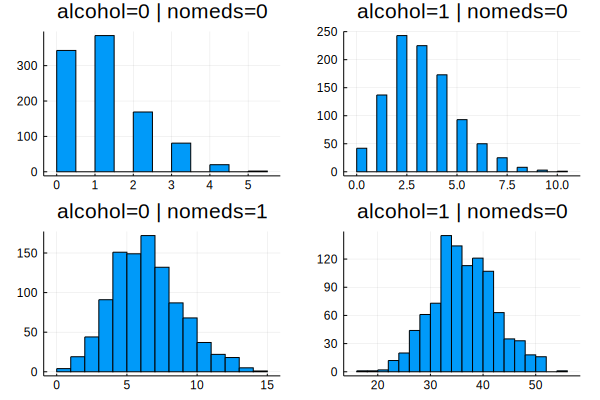

In [4]:
p1 = Plots.histogram(df_pois[1:1000, 1], title = "alcohol=0 | nomeds=0")  
p2 = Plots.histogram((df_pois[1001:2000, 1]), title = "alcohol=1 | nomeds=0")  
p3 = Plots.histogram((df_pois[2001:3000, 1]), title = "alcohol=0 | nomeds=1")  
p4 = Plots.histogram((df_pois[3001:4000, 1]), title = "alcohol=1 | nomeds=0")  
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

## Negative Binomial Data

Now, suppose every subject in the dataset had the flu, increasing the variance of their sneezing (and causing an unfortunate few to sneeze over 70 times a day). If the mean number of sneezes stays the same but variance increases, the data might follow a negative binomial distribution.

In [5]:
# Gamma shape parameter
α = 10

function get_nb_vals(μ, α, size)
    θ = μ/α
    g = rand(Gamma(α, θ), size)
    return [rand(Poisson(g[i])) for i = 1:size]
end

#Generate data from different Negative Binomial distribution
q = 1000

df = DataFrame(
        nsneeze=vcat(get_nb_vals(θ_noalcohol_meds, α, q),
                get_nb_vals(θ_alcohol_meds, α, q),
                get_nb_vals(θ_noalcohol_nomeds, α, q),
                get_nb_vals(θ_alcohol_nomeds, α, q)),
        alcohol=vcat(zeros(q),
                ones(q),
                zeros(q),
                ones(q)),
        nomeds=vcat(zeros(q),
                zeros(q),
                ones(q),
                ones(q)));

**View means of the various combinations (Negative Binomial)**

In [6]:
by(df, [:nomeds, :alcohol], :nsneeze => mean, :nsneeze => var)

,nomeds,alcohol,nsneeze_mean,nsneeze_var
,Float64,Float64,Float64,Float64
1,0.0,0.0,1.039,1.04853
2,0.0,1.0,3.033,3.99791
3,1.0,0.0,6.042,9.58582
4,1.0,1.0,36.032,156.253


### Visualize the Data

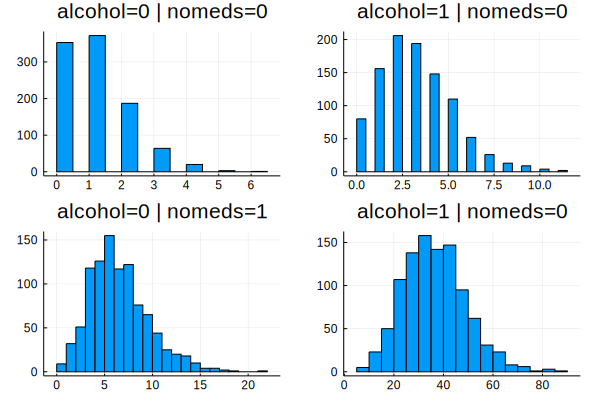

In [7]:
p1 = Plots.histogram(df[1:1000, 1], title = "alcohol=0 | nomeds=0")  
p2 = Plots.histogram((df[1001:2000, 1]), title = "alcohol=1 | nomeds=0")  
p3 = Plots.histogram((df[2001:3000, 1]), title = "alcohol=0 | nomeds=1")  
p4 = Plots.histogram((df[3001:4000, 1]), title = "alcohol=1 | nomeds=0")  
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

**Convert the DataFrame object to matrices.**

We must convert our `DataFrame` data into the `Matrix` form as the manipulations that we are about are designed to work with `Matrix` data. We also separate the features from the labels which will be later used by the Turing sampler to generate samples from the posterior.

In [8]:
data = Matrix(df[[:alcohol, :nomeds]])
data_labels = df[:nsneeze];

**Rescale the matrices.**

In [9]:
data = (data .- mean(data, dims=1)) ./ std(data, dims=1);

## Model: Negative Binomial Regression

Our model *negative_binomail_regression* takes two arguments:
* X: Set of independent variables
* y: Set we want to predict

In the model use the following algorithm:
$$
\beta\sim Normal(\mu0, \Sigma)\\
\text{where }\mu0 = zeros(D+1)\\
\text{and }\Sigma = Diagonal(D+1)\\
r\sim Gamma(1, 1)\\
$$
For $n = 1:N$
$$
\mu = \exp{(\beta[1] + \beta[2:end] \cdot X[n,:])}\\
p = \frac{r * \mu}{1 + r * \mu}\\
y[n]\sim NegativeBinomial(r, p)\\
$$

Intutively, we can think the coefficients as:
* β[0] as the constant coefficient
* β[1] as the coefficient which represents the effect of taking no medicines on `nsneezes`
* β[2] as the coefficient which represents the effect of taking alcohol on `nsneezes`

In [10]:
@model m(X, y) = begin
    N, D = size(X)
    β ~ MvNormal(zeros(D+1), Diagonal(ones(D+1)))
    r ~ Gamma()
    for n in 1:N
        μ = exp(β[1] + dot(β[2:end], X[n, :]))
        p = (r * μ) / (1 + r * μ)
        y[n] ~ NegativeBinomial(r, p)
    end
end;

m (generic function with 3 methods)

### Sampling from the posterior

We use **NUTS** sampler to sample values from the posterior

In [ ]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using NUTS.

num_chains = 4
chns = mapreduce(c -> sample(m(data, data_labels), NUTS(1500, 200, 0.65) ), chainscat, 1:num_chains)

# describe(chain)

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info: [Turing] found initial ϵ: 0.012666368484497072
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ W

[NUTS] Finished with
  Running time        = 569.1783172240006;
  #lf / sample        = 0.0;
  #evals / sample     = 27.681333333333335;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info: [Turing] found initial ϵ: 0.014000177383422852
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info:  Adapted ϵ = 0.0031217115147587457, std = [1.0, 1.0, 1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/riteshk/.julia/p

[NUTS] Finished with
  Running time        = 1096.526534234001;
  #lf / sample        = 0.0;
  #evals / sample     = 55.04;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info: [Turing] found initial ϵ: 0.0157740592956543
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info:  Adapted ϵ = 0.008239147058686634, std = [1.0, 1.0, 1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/riteshk/.julia/pack

[NUTS] Finished with
  Running time        = 480.12900249399956;
  #lf / sample        = 0.0;
  #evals / sample     = 24.338;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info: [Turing] found initial ϵ: 0.013036584854125979
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/riteshk/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170


### Viewing the Diagnostics and Visualising the Posterior

In [ ]:
gelmandiag(chns)

In [ ]:
chn = chns[:,:,1]
β0_exp = exp(mean(chn[:1].value))
β1_exp = exp(mean(chn[:2].value))
β2_exp = exp(mean(chn[:3].value))
print("The exponent of the meaned values of the weights (or coefficients are): \n")
print("b0: ", b0_exp, " \n", "b1: ", b1_exp, " \n", "b2: ", b2_exp, " \n", "b3: ", b3_exp, " \n")
print("The posterior distributions obtained after sampling can be visualised as :\n")
plot(chn)